In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib
import pandas as pd
import os
import re
from tqdm import tqdm

color_array=np.linspace(0,1,11)
cmap = plt.cm.tab20b

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the notebook wider
plt.style.use('default')

/var/folders/kf/hx5km7bs4hg_5ytlj6pnz_100000gn/T/ipykernel_14239/1930717304.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from  pygama.dsp.processors.trap_filters import trap_filter
from  pygama.dsp.processors.trap_filters import trap_norm

In [3]:
#Adapted from LEGEND pygama software
def trap(waveform, rampTime=150, flatTime=250, decayTime=0, baseline=0.):
    """
    Apply a trap filter to a waveform.
    """
    decayConstant = 0.
    norm = rampTime
    if decayTime != 0:
        decayConstant = 1. / (np.exp(1. / decayTime) - 1)
        norm *= decayConstant

    trapOutput = np.zeros_like(waveform)
    fVector = np.zeros_like(waveform)
    scratch = np.zeros_like(waveform)
    fVector[0] = waveform[0] - baseline
    trapOutput[0] = (decayConstant + 1.) * (waveform[0] - baseline)

    wf_minus_ramp = np.zeros_like(waveform)
    wf_minus_ramp[:rampTime] = baseline
    wf_minus_ramp[rampTime:] = waveform[:len(waveform) - rampTime]

    wf_minus_ft_and_ramp = np.zeros_like(waveform)
    wf_minus_ft_and_ramp[:(flatTime + rampTime)] = baseline
    wf_minus_ft_and_ramp[(flatTime + rampTime):] = waveform[:len(waveform) - flatTime - rampTime]

    wf_minus_ft_and_2ramp = np.zeros_like(waveform)
    wf_minus_ft_and_2ramp[:(flatTime + 2 * rampTime)] = baseline
    wf_minus_ft_and_2ramp[(flatTime + 2 * rampTime):] = waveform[:len(waveform) - flatTime -
                                              2 * rampTime]

    scratch = waveform - (wf_minus_ramp +
                          wf_minus_ft_and_ramp - # NOTE: clint changed this to - after walter convinced him
                          wf_minus_ft_and_2ramp)

    if decayConstant != 0:
        fVector = np.cumsum(fVector + scratch)
        trapOutput = np.cumsum(trapOutput + fVector + decayConstant * scratch)
    else:
        trapOutput = np.cumsum(trapOutput + scratch)

    # Normalize and resize output
    tmp_hi = len(waveform) - (2 * rampTime + flatTime)
    trapOutput[:tmp_hi] = trapOutput[2 * rampTime + flatTime:] / norm
    trapOutput.resize((len(waveform) - (2 * rampTime + flatTime)))
    return trapOutput

In [45]:
n_iter = 4000
time_step_calc = 0.2
step_time_out = 1
time = np.linspace(start=0, stop= int (n_iter*time_step_calc - step_time_out*time_step_calc ), num= (int) (n_iter/step_time_out))
print(time)

[0.0000000e+00 1.9979995e-01 3.9959990e-01 ... 7.9860040e+02 7.9880020e+02
 7.9900000e+02]


In [60]:
n_iter = 4000/0.2
time_step_calc = 0.2
step_time_out = 1
time = np.linspace(start=0, stop= int (n_iter*time_step_calc - step_time_out*time_step_calc ), num= (int) (n_iter/step_time_out))
print(time)

[0.00000000e+00 1.99959998e-01 3.99919996e-01 ... 3.99860008e+03
 3.99880004e+03 3.99900000e+03]


In [6]:
trap_in = np.loadtxt('/Users/kevinhbhimani/Desktop/siggen_sims/GPU_work/siggen_ccd/waveforms/800.00_keV/grid_0.0200/self_repulsion_1/P42575A/q=0.00/signal_r=20.00_phi=0.00_z=5.05.txt')
print(len(trap_in))

20000


Text(0.5, 0, 'Time (ns)')

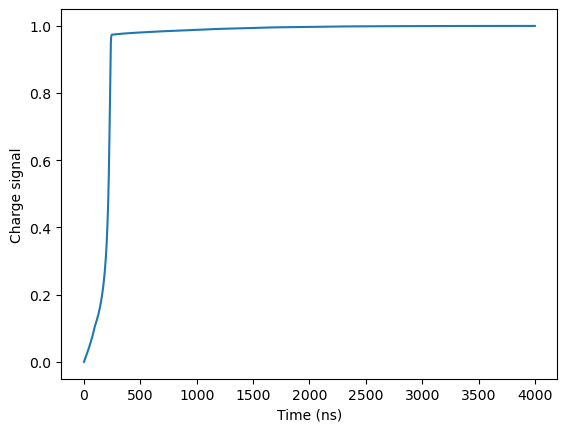

In [7]:
plt.plot(time,trap_in)
plt.ylabel('Charge signal')
plt.xlabel('Time (ns)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
# plt.title('Max energy using SR - max energy without SR at radius=25.00')
# plt.legend(['z=0.05','z=0.10','z=0.15','z=0.20','z=0.50','z=1.00','z=2.00','z=3.00','z=5.00','z=10.00'])

In [38]:
# rise time of 4 us and a flat top of 2.5 us. We pick off the energy at 6 us from the start time
# Parameters
# w_in (ndarray) -- the input waveform.

# rise (int) -- the number of samples averaged in the rise and fall sections.

# flat (int) -- the delay between the rise and fall sections.

# w_out (ndarray) -- the filtered waveform
rise_time = 500 #ns
flat_top = 2500 #ns
pickup = 3000 #ns
trap_out = np.zeros(len(trap_in))
trap_norm(trap_in, int(rise_time/time_step_calc), int(flat_top/time_step_calc), trap_out)
print(len(trap_out))

20000


energy collected at pickup 0.9989470067999995


Text(0.5, 0, 'Time (ns)')

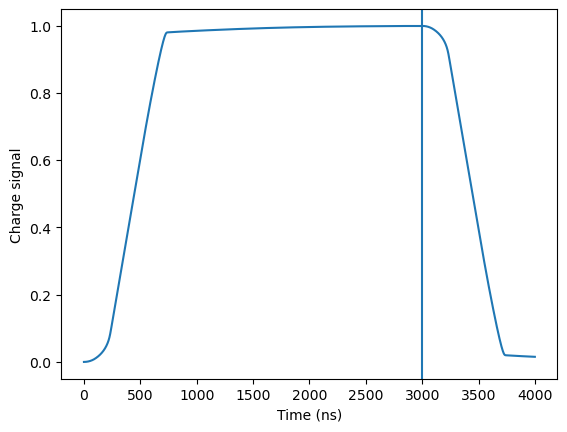

In [62]:
plt.plot(time,trap_out)
plt.axvline(x=pickup)
print("energy collected at pickup", trap_out[(int)(pickup/time_step_calc)])
plt.ylabel('Charge signal')
plt.xlabel('Time (ns)')

In [10]:
energy=np.array([])
grid=np.array([])
sr=np.array([])
detector=np.array([])
surface_charge=np.array([])
radius=np.array([])
height=np.array([])
phi=np.array([])
charge_data = np.empty((0,len(time)),dtype=float)

directory = '/Users/kevinhbhimani/Desktop/siggen_sims/GPU_work/waveforms_low-E'


In [11]:
for filename in tqdm(os.listdir(directory)):
    if('_keV' in filename):
        energy_val = filename.split("_")[0]
        for filename_g in (os.listdir(directory + '/' + filename)):
            if('grid' in directory + '/' + filename_g):
                grid_val = filename_g.split("_")[1]
                for filename_e in (os.listdir(directory + '/' + filename + '/' + filename_g)):
                    if('self_repulsion' in filename_e):
                        sr_val = filename_e.split("_")[2]
                        for filename_sr in (os.listdir(directory + '/' + filename + '/' + filename_g + '/' + filename_e)):
                            if (filename_sr.startswith('.')) == False:
                                det_val = filename_sr
                                for filename_det in (os.listdir(directory + '/' + filename + '/' + filename_g + '/' + filename_e + '/' + filename_sr)):
                                    if ('q=' in filename_det):
                                        q_val = filename_det.split("=")[1]
                                        for filename_q in (os.listdir(directory+'/'+filename+'/'+ filename_g+'/'+filename_e+'/'+filename_sr+'/'+filename_det)):
                                            if('signal_' in filename_q):
                                                r_val = filename_q.split("_")[1].split("=")[1]
                                                phi_val = filename_q.split("_")[2].split("=")[1]
                                                z_temp = filename_q.split("_")[3].split("=")[1].split(".")
                                                z_val = z_temp[0]+"."+z_temp[1]
                                                energy = np.append(energy, float(energy_val))
                                                grid = np.append(grid,float(grid_val))
                                                radius = np.append(radius, float(r_val))
                                                height = np.append(height, float(z_val))
                                                phi = np.append(phi, float(phi_val))
                                                sr = np.append(sr, float(sr_val))
                                                surface_charge = np.append(surface_charge, float(q_val))
                                                data = np.loadtxt(directory+'/'+filename+'/'+filename_g+'/'+filename_e+'/'+filename_sr+'/'+filename_det+'/'+ filename_q)
                                                charge_data = np.vstack([charge_data, data])


  0%|                                                     | 0/6 [00:00<?, ?it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 20000 and the array at index 1 has size 400

In [ ]:
print(charge_data[sr==1])

In [ ]:
# plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==5.00)&(grid==0.010)&(energy==5000.00)][0],'-',markersize=2,color='tab:green')
# #plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==0.02)&(grid==0.015)&(energy==5000.00)][0],'-',markersize=2,color='tab:purple')
# plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==5.00)&(grid==0.020)&(energy==5000.00)][0],'-',markersize=2,color='tab:orange')
# # plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==0.10)&(grid==0.025)&(energy==5000.00)][0],'-',markersize=2,color='tab:red')
# # plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==0.10)&(grid==0.03)&(energy==5000.00)][0],'-',markersize=2,color='tab:blue')
# # plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==0.10)&(grid==0.035)&(energy==5000.00)][0],'-',markersize=2,color='tab:grey')
# # plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==0.10)&(grid==0.04)&(energy==5000.00)][0],'-',markersize=2,color='tab:olive')

# plt.legend(['0.0100 with initial density split over 8 voxels, time step=0.2', '0.0200 with initial density split over 2 voxels, time step=0.2'])

# plt.xlabel('Time (ns)')
# plt.ylabel('Charge signal')
# plt.title('Signal collected for various grid sizes, $r=15,z=5.00$, SR=1, Energy=$5$MeV')

In [ ]:
# plt.plot(time,charge_data[(radius==15)&(sr==1)&(height==5.00)&(grid==0.010)&(energy==5000.00)][0]-charge_data[(radius==15)&(sr==1)&(height==5.00)&(grid==0.020)&(energy==5000.00)][0],'-',markersize=2,color='tab:red')
# #plt.legend(['0.0100', '0.0150', '0.0200'])

# plt.xlabel('Time (ns)')
# plt.ylabel('Charge signal')
# plt.title('Signal collected for at $10\mu$ grid- $20\mu$grid , $r=15,z=5.00$, SR=1, Energy=$5$MeV')

In [ ]:
# plt.plot(time, charge_data[(energy==600)&(radius==15)&(sr==1)&(height==0.50)][0],'-',markersize=1,color='tab:green')
# plt.ylabel('Charge signal')
# plt.xlabel('Time')
# #plt.title('Max energy collected using SR - max energy collected without SR, height=0.50')

In [ ]:
collected_sr = np.max(charge_data[(radius==25)&(sr==1)&(height==0.05)],axis=1)
collected_wsr = np.max(charge_data[(radius==25)&(sr==0)&(height==0.05)],axis=1)

In [ ]:
cor_energy = energy[(radius==25)&(sr==1)&(height==0.05)]
cor_radius = radius[(energy==600)&(sr==1)&(height==0.05)]
c_rad_sr = np.max(charge_data[(energy==600)&(sr==1)&(height==0.05)],axis=1)
c_rad= np.max(charge_data[(energy==600)&(sr==0)&(height==0.05)],axis=1)

In [ ]:
plt.plot(energy[(radius==25)&(sr==1)&(height==0.05)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.05)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.05)], np.max(charge_data[(radius==25)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:green')
#plt.plot(cor_energy, collected_sr-collected_wsr,'o',markersize=5,color='tab:red')

#plt.ylim([0.9, 1.1])

plt.ylabel('Charge signal')
plt.xlabel('Energy (keV)')
plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Signal collected for events at $r=25.00$ mm, $z=0.05$ mm') #for surface charge=0.00 e10 e/cm$^2$
#plt.savefig('/Users/kevinhbhimani/Desktop/Thesis_proposal_figs/low_e_sr_sig.png')


In [ ]:
plt.plot(energy[(radius==5)&(sr==1)&(height==0.05)],np.max(charge_data[(radius==5)&(sr==1)&(height==0.05)],axis=1)-np.max(charge_data[(radius==5)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:green')
plt.plot(energy[(radius==15)&(sr==1)&(height==0.05)],np.max(charge_data[(radius==15)&(sr==1)&(height==0.05)],axis=1)-np.max(charge_data[(radius==15)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.05)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.05)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:cyan')



plt.ylabel('Charge signal')
plt.xlabel('Energy (keV)')
plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Max energy using SR - max energy without SR  height=0.05')
plt.legend(['radius=5','radius=15','radius=25'])




In [ ]:
plt.plot(energy[(radius==25)&(sr==1)&(height==0.05)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.05)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:green')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.10)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.10)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.10)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.15)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.15)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.15)],axis=1),'o',markersize=5,color='tab:cyan')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.20)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.20)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.20)],axis=1),'o',markersize=5,color='tab:orange')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.50)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.50)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.50)],axis=1),'o',markersize=5,color='tab:blue')
plt.plot(energy[(radius==25)&(sr==1)&(height==1.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==1.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==1.00)],axis=1),'o',markersize=5,color='tab:red')
plt.plot(energy[(radius==25)&(sr==1)&(height==2.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==2.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==2.00)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(energy[(radius==25)&(sr==1)&(height==3.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==3.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==3.00)],axis=1),'o',markersize=5,color='tab:pink')
plt.plot(energy[(radius==25)&(sr==1)&(height==5.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==5.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==5.00)],axis=1),'o',markersize=5,color='tab:grey')
plt.plot(energy[(radius==25)&(sr==1)&(height==10.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==10.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==10.00)],axis=1),'o',markersize=5,color='tab:olive')


plt.ylabel('Charge signal')
plt.xlabel('Energy (keV)')
plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Max energy using SR - max energy without SR at radius=25.00')
plt.legend(['z=0.05','z=0.10','z=0.15','z=0.20','z=0.50','z=1.00','z=2.00','z=3.00','z=5.00','z=10.00'])

In [ ]:
c_height = height[(energy==600)&(radius==25)&(sr==1)]
c_height_col_sr = np.max(charge_data[(energy==600)&(radius==25)&(sr==1)],axis=1)
c_height_col = np.max(charge_data[(energy==600)&(radius==25)&(sr==0)],axis=1)

In [ ]:
plt.plot(c_height,np.max(charge_data[(energy==600)&(radius==25)&(sr==1)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(c_height, np.max(charge_data[(energy==600)&(radius==25)&(sr==0)],axis=1),'o',markersize=5,color='tab:green')

plt.ylabel('Charge signal')
plt.xlabel('Height (mm)')
plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Max signal at event with Energy = 600 keV, $r=25.00$ mm')

In [ ]:
plt.plot(cor_radius,np.max(charge_data[(energy==600)&(sr==1)&(height==0.05)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(cor_radius, np.max(charge_data[(energy==600)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:green')

plt.ylabel('Charge signal')
plt.xlabel('Radius (mm)')
plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Energy = 600 keV, $z=0.05$ mm')

In [ ]:
plt.plot(energy[(radius==20)&(sr==1)&(height==0.05)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.05)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.05)],axis=1),'o',markersize=5,color='tab:green')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.10)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.10)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.10)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.15)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.15)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.15)],axis=1),'o',markersize=5,color='tab:cyan')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.20)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.20)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.20)],axis=1),'o',markersize=5,color='tab:orange')
plt.plot(energy[(radius==25)&(sr==1)&(height==0.50)],np.max(charge_data[(radius==25)&(sr==1)&(height==0.50)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==0.50)],axis=1),'o',markersize=5,color='tab:blue')
plt.plot(energy[(radius==25)&(sr==1)&(height==1.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==1.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==1.00)],axis=1),'o',markersize=5,color='tab:red')
plt.plot(energy[(radius==25)&(sr==1)&(height==2.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==2.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==2.00)],axis=1),'o',markersize=5,color='tab:purple')
plt.plot(energy[(radius==25)&(sr==1)&(height==3.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==3.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==3.00)],axis=1),'o',markersize=5,color='tab:pink')
plt.plot(energy[(radius==25)&(sr==1)&(height==5.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==5.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==5.00)],axis=1),'o',markersize=5,color='tab:grey')
plt.plot(energy[(radius==25)&(sr==1)&(height==10.00)],np.max(charge_data[(radius==25)&(sr==1)&(height==10.00)],axis=1)-np.max(charge_data[(radius==25)&(sr==0)&(height==10.00)],axis=1),'o',markersize=5,color='tab:olive')


plt.ylabel('Charge signal')
plt.xlabel('Energy (keV)')
plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Max energy using SR - max energy without SR at radius=25.00')
plt.legend(['z=0.05','z=0.10','z=0.15','z=0.20','z=0.50','z=1.00','z=2.00','z=3.00','z=5.00','z=10.00'])

In [ ]:
cut_z = (radius==20)&(sr_val==1)&(grid==0.02)&(energy==800)
norm = plt.Normalize()
colors = plt.cm.jet(norm(height[cut_z]))
for z in tqdm(height):
    cut = (radius==20)&(sr==1)&(height==z)&(grid==0.02)&(energy==800)
#     cut_2 = (radius==20)&(sr_val==0)&(height==z)&(grid==0.02)&(energy==800)
    plt.plot(height[cut],np.max(charge_data[cut],axis=1),'o',markersize=5, color=plt.cm.jet(z/max(height)))
#     plt.plot(height[cut_2],np.max(charge_data[cut_2],axis=1),'o',markersize=5, color=plt.cm.summer(z/max(height)))
plt.ylabel('Charge signal')
plt.xlabel('Height (mm)')
# plt.legend(['with self-repulsion', 'without self-repulsion'])
plt.title('Fraction of charged collected at various height without SR, Energy=800keV')
# plt.legend(['z=0.05','z=0.10','z=0.15','z=0.20','z=0.50','z=1.00','z=2.00','z=3.00','z=5.00','z=10.00'])
plt.show()

In [ ]:
cut = (radius==20)&(sr==1)&(height==5.05)&(grid==0.02)&(energy==800)
print(np.max(charge_data[cut],axis=1))